# Example of Comparing All Implemented Outlier Detection Models

**[PyOD](https://github.com/yzhao062/pyod)** is a comprehensive **Python toolkit** to **identify outlying objects** in 
multivariate data with both unsupervised and supervised approaches.
The model covered in this example includes:

  1. Linear Models for Outlier Detection:
     1. **PCA: Principal Component Analysis** use the sum of
       weighted projected distances to the eigenvector hyperplane 
       as the outlier outlier scores)
     2. **MCD: Minimum Covariance Determinant** (use the mahalanobis distances 
       as the outlier scores)
     3. **OCSVM: One-Class Support Vector Machines**
     
  2. Proximity-Based Outlier Detection Models:
     1. **LOF: Local Outlier Factor**
     2. **CBLOF: Clustering-Based Local Outlier Factor**
     3. **kNN: k Nearest Neighbors** (use the distance to the kth nearest 
     neighbor as the outlier score)
     4. **Median kNN** Outlier Detection (use the median distance to k nearest 
     neighbors as the outlier score)
     5. **HBOS: Histogram-based Outlier Score**
     
  3. Probabilistic Models for Outlier Detection:
     1. **ABOD: Angle-Based Outlier Detection**
  
  4. Outlier Ensembles and Combination Frameworks
     1. **Isolation Forest**
     2. **Feature Bagging**
     3. **LSCP**
     
Corresponding file could be found at /examples/compare_all_models.py

In [1]:
from __future__ import division
from __future__ import print_function

import os
import sys
from time import time

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager

# Import all models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP

In [2]:
# Define the number of inliers and outliers
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [5]

# Compare given detectors under given settings
# Initialize the data
xx, yy = np.meshgrid(np.linspace(-7, 7, 100), np.linspace(-7, 7, 100))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.zeros(n_samples, dtype=int)
ground_truth[-n_outliers:] = 1

# initialize a set of detectors for LSCP
detector_list = [LOF(n_neighbors=5), LOF(n_neighbors=10), LOF(n_neighbors=15),
                 LOF(n_neighbors=20), LOF(n_neighbors=25), LOF(n_neighbors=30),
                 LOF(n_neighbors=35), LOF(n_neighbors=40), LOF(n_neighbors=45),
                 LOF(n_neighbors=50)]

In [3]:
# Show the statics of the data
print('Number of inliers: %i' % n_inliers)
print('Number of outliers: %i' % n_outliers)
print('Ground truth shape is {shape}. Outlier are 1 and inliers are 0.\n'.format(shape=ground_truth.shape))
print(ground_truth)

Number of inliers: 150
Number of outliers: 50
Ground truth shape is (200,). Outlier are 1 and inliers are 0.

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [4]:
random_state = np.random.RandomState(42)
# Define nine outlier detection tools to be compared
classifiers = {
    'ABOD':
        ABOD(contamination=outliers_fraction),
    'CBLOF':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    'Feature Bagging':
        FeatureBagging(LOF(n_neighbors=35),
                       contamination=outliers_fraction,
                       random_state=random_state),
    'HBOS': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                behaviour="new",
                                random_state=random_state),
    'KNN': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'LOF':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'MCD': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'OCSVM': OCSVM(contamination=outliers_fraction),
    'PCA': PCA(
        contamination=outliers_fraction, random_state=random_state),
    'LSCP': LSCP(
        detector_list, contamination=outliers_fraction,
        random_state=random_state)
}

1 fitting CBLOF
2 fitting Feature Bagging
3 fitting HBOS
4 fitting Isolation Forest
5 fitting KNN
6 fitting Average KNN
7 fitting LOF
8 fitting MCD
9 fitting OCSVM
10 fitting PCA
11 fitting LSCP


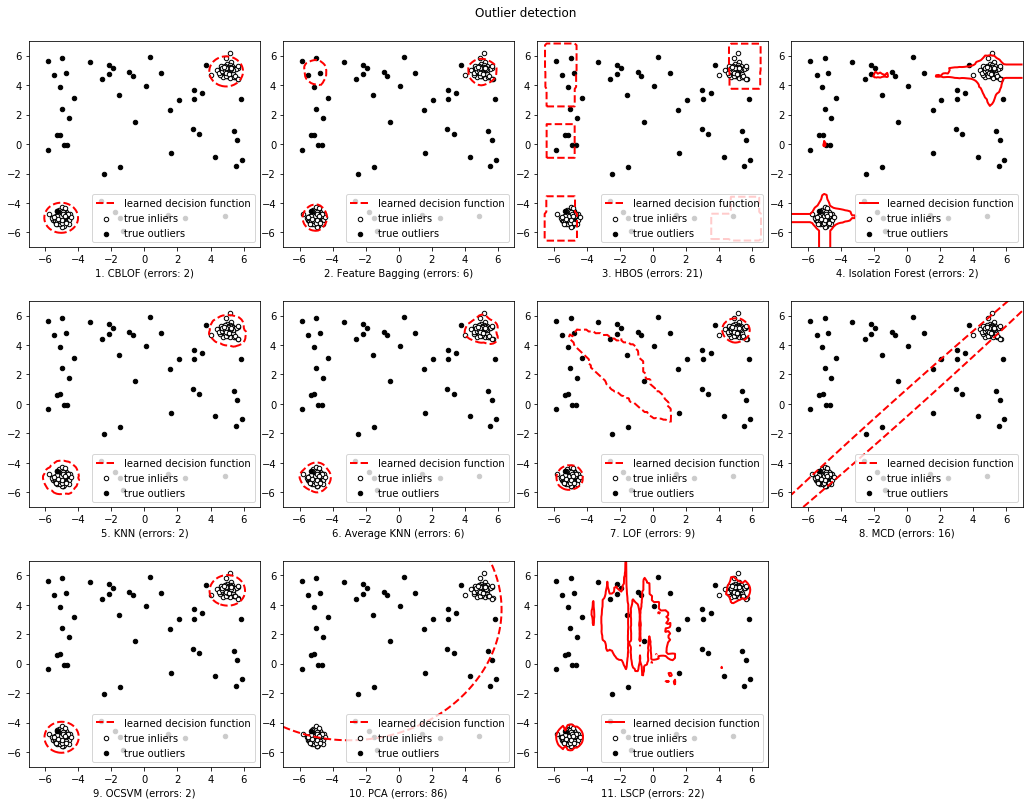

In [5]:
# Fit the models with the generated data and 
# compare model performances
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(15, 12))
    for i, (clf_name, clf) in enumerate(list(classifiers.items())[1:]):
        print(i + 1, 'fitting', clf_name)
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X) * -1
        y_pred = clf.predict(X)
        threshold = percentile(scores_pred, 100 * outliers_fraction)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points

        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(3, 4, i + 1)
        #subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
        #                 cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        #subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
        #                 colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white',
                            s=20, edgecolor='k')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black',
                            s=20, edgecolor='k')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=10),
            loc='lower right')
        subplot.set_xlabel("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.94, 0.1, 0.26)
    plt.suptitle("Outlier detection")
plt.show()